In [56]:
import os
import pickle
from pathlib import Path
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science', 'std-colors'])
plt.rcParams['figure.dpi'] = 200
plt.rcParams['font.size'] = 8
plt.rcParams['axes.labelsize'] = 8
plt.rcParams['xtick.labelsize'] = 7
plt.rcParams['ytick.labelsize'] = 7
from copy import deepcopy
import numpy as np
import ml_confs
configs = ml_confs.from_file('configs.yaml', register_jax_pytree=False)
configs.tabulate()

┏━━━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃ Key           ┃ Value ┃ Type  ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ classes       │ 5     │ int   │
│ train_samples │ 1001  │ int   │
│ val_ratio     │ 0.2   │ float │
│ test_samples  │ 1001  │ int   │
│ num_rng_seeds │ 20    │ int   │
│ batch_size    │ 128   │ int   │
│ eval_up_to_t  │ 15    │ int   │
│ reduced_rank  │ True  │ bool  │
│ max_epochs    │ 150   │ int   │
│ trial_budget  │ 50    │ int   │
└───────────────┴───────┴───────┘

In [58]:
#List and unpickle all files in "results/"
reports = {}
for file in os.listdir("results/"):
    if file.endswith(".pkl"):
        with open("results/"+file, "rb") as f:
            restored_report = pickle.load(f)
            model_name = restored_report.pop("name")
            reports[model_name] = restored_report

def timing_report(report):
    fit_time = f"${report['fit_time']:0.3f}"
    if 'fit_time_std' in report:
        fit_time += f" \pm {report['fit_time_std']:0.3f}$"
    else:
        fit_time += "$"
    if 'time_per_epoch' in report:
        time_per_epoch = f"${report['time_per_epoch']:0.3f}"
        if 'time_per_epoch_std' in report:
            time_per_epoch += f" \pm {report['time_per_epoch_std']:0.3f}$"
        else:
            time_per_epoch += "$"
    else:
        time_per_epoch = "-"
    return fit_time, time_per_epoch

def pt_to_inch(pt):
    return pt/72.27

def figsize(wratio = 1, width_to_height = 3/2, text_width_pt = 397):
    w = pt_to_inch(text_width_pt)*wratio
    h = w/width_to_height
    return (w,h)

In [49]:
for model_name in reports.keys():
    print(model_name)

DynamicalAE
DPNets-relaxed
Oracle-Features
DMD
KernelDMD-Poly3
KernelDMD-AbsExp
KernelDMD-RBF
DPNets
ConsistentAE


In [50]:
ordered_models = [
    'DPNets',
    'DPNets-relaxed',
    'Oracle-Features',
    'VAMPNets',
    'DynamicalAE',
    'ConsistentAE',
    'DMD',
    'KernelDMD-Poly3',
    'KernelDMD-RBF',
    'KernelDMD-AbsExp'
]

In [51]:
for mn in ordered_models:
    print ('DMD' in mn)

False
False
False
False
False
False
True
True
True
True


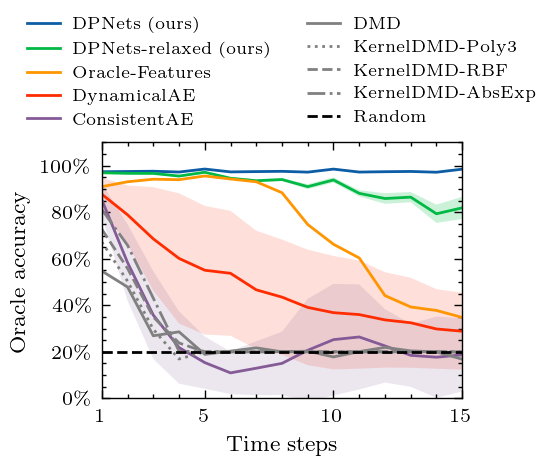

In [70]:
fig, ax = plt.subplots(figsize=figsize(0.5, 10/9.))
dmd_ls = ['solid', 'dotted', 'dashed', 'dashdot']
for model_name in ordered_models:
    if model_name in reports:
        report = reports[model_name]
        t = list(range(1, configs.eval_up_to_t + 1))
        acc = np.array(report['accuracy'])
        acc_std = np.array(report.get('accuracy_std', np.zeros_like(acc)))      
        if model_name in ['DPNets', 'DPNets-relaxed']:
            model_name = model_name + ' (ours)'
            ax.plot(t, acc, '-', lw=1.0, label=model_name)
            ax.fill_between(t, acc - acc_std, acc + acc_std, alpha=0.2)
        elif 'DMD' in model_name:
            
            ax.plot(t, acc, color='gray', ls = dmd_ls.pop(0), label=model_name)
            ax.fill_between(t, acc - acc_std, acc + acc_std, alpha=0.15)
        else:
            ax.plot(t, acc, '-', label=model_name)
            ax.fill_between(t, acc - acc_std, acc + acc_std, alpha=0.15)

ax.axhline(1/configs.classes, color='black', linestyle='--', label='Random')

ax.legend(frameon=False, loc='lower center', bbox_to_anchor=(0, 1, 1, 0), ncol=2, fontsize=6)
ax.margins(x=0)
ax.set_ylim(0, 1.1)
#Add y ticks for every 20% of accuracy
ax.set_yticks(np.arange(0, 1.1, 0.2))
ax.set_yticklabels([f'{i*100:.0f}\%' for i in np.arange(0, 1.1, 0.2)])
ax.set_xticks([1, 5, 10, 15])
ax.set_xlabel('Time steps')
ax.set_ylabel('Oracle accuracy')
fig.tight_layout()
fig.savefig('figures/oracle_accuracy.pdf')
fig.savefig('figures/oracle_accuracy.png')


In [10]:
from tabulate import tabulate

In [11]:
headers = [r"\textbf{Model}", r"\textbf{Fit Time (s)}", r"\textbf{Time per Epoch (s)}"]
table_records = []
for report in reports:
    table_records.append(timing_report(report))
print(tabulate(table_records, headers=headers, tablefmt="latex_raw", colalign=("right", "center", "center")))

\begin{tabular}{rcc}
\hline
   \textbf{Model} &  \textbf{Fit Time (s)}  &  \textbf{Time per Epoch (s)}  \\
\hline
      DynamicalAE &    $7.853 \pm 0.080$    &       $0.052 \pm 0.001$       \\
   DPNets-relaxed &    $0.068 \pm 0.057$    &       $0.046 \pm 0.001$       \\
  Oracle-Features &         $0.098$         &               -               \\
              DMD &         $0.333$         &               -               \\
  KernelDMD-Poly3 &         $4.914$         &               -               \\
 KernelDMD-AbsExp &         $0.832$         &               -               \\
    KernelDMD-RBF &         $0.776$         &               -               \\
           DPNets &    $0.059 \pm 0.016$    &       $0.048 \pm 0.001$       \\
\hline
\end{tabular}
